In [0]:
%pip install xgboost

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, hour, dayofweek, month, year, to_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
import time
import pandas as pd
from pyspark.ml.feature import Normalizer
#import xgboost as xgb


In [0]:
spark = SparkSession.builder.appName("Prediction System Cloud").getOrCreate()

In [0]:
# Charger les fichiers CSV
df_2017 = spark.read.csv("/FileStore/tables/BTC_2017min.csv", header=True, inferSchema=True)
df_2018 = spark.read.csv("/FileStore/tables/BTC_2018min.csv", header=True, inferSchema=True)
df_2019 = spark.read.csv("/FileStore/tables/BTC_2019min.csv", header=True, inferSchema=True)
df_2020 = spark.read.csv("/FileStore/tables/BTC_2020min.csv", header=True, inferSchema=True)
df_2021 = spark.read.csv("/FileStore/tables/BTC_2021min.csv", header=True, inferSchema=True)

# Concaténer les ensembles de données
df = df_2017.union(df_2018).union(df_2019).union(df_2020).union(df_2021)


In [0]:
df.printSchema()

root
 |-- unix: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- symbol: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- Volume BTC: double (nullable = true)
 |-- Volume USD: double (nullable = true)



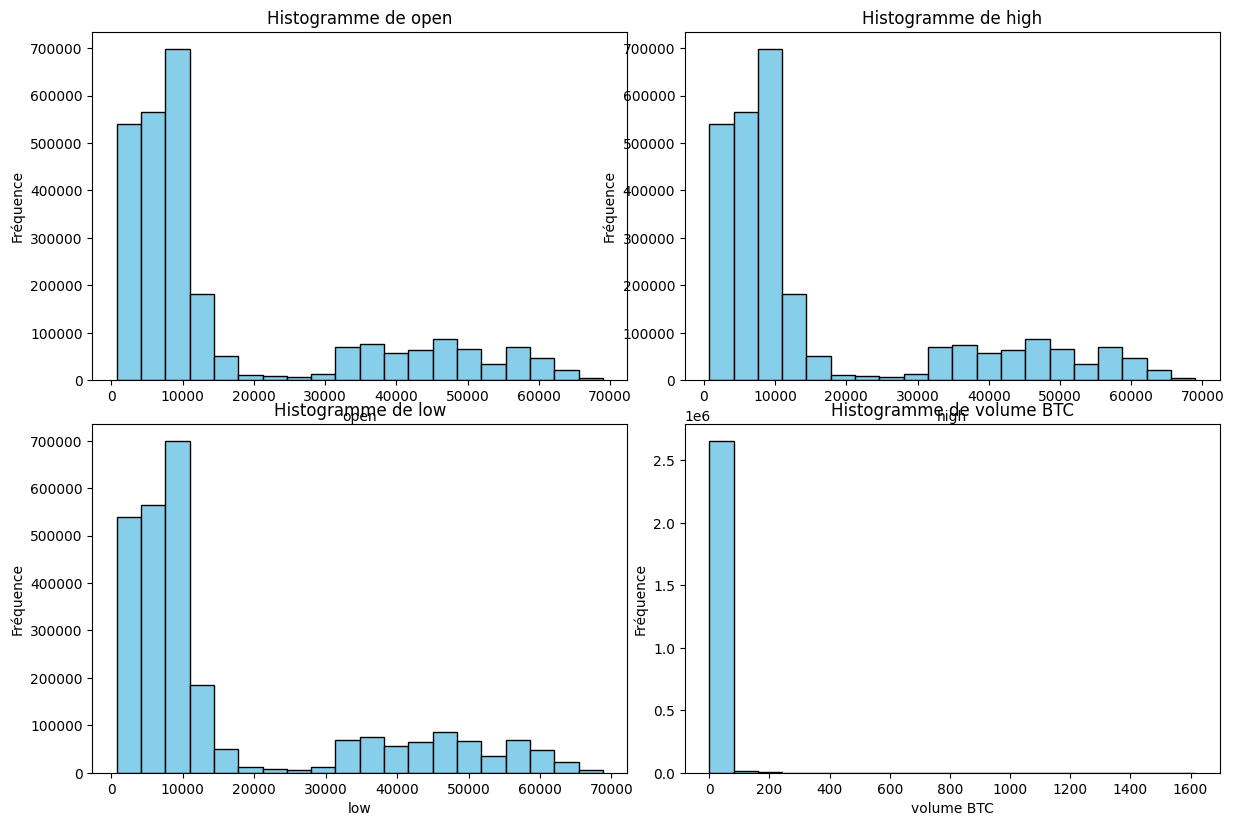

In [0]:
import matplotlib.pyplot as plt

# Liste des variables continues
continuous_vars = ['open', 'high', 'low', 'volume BTC']

# Création d'histogrammes pour chaque variable continue
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout()

for i, var in enumerate(continuous_vars):
    ax = axs[i//2, i%2]
    ax.hist(df.select(var).rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f"Histogramme de {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Fréquence")

plt.show()

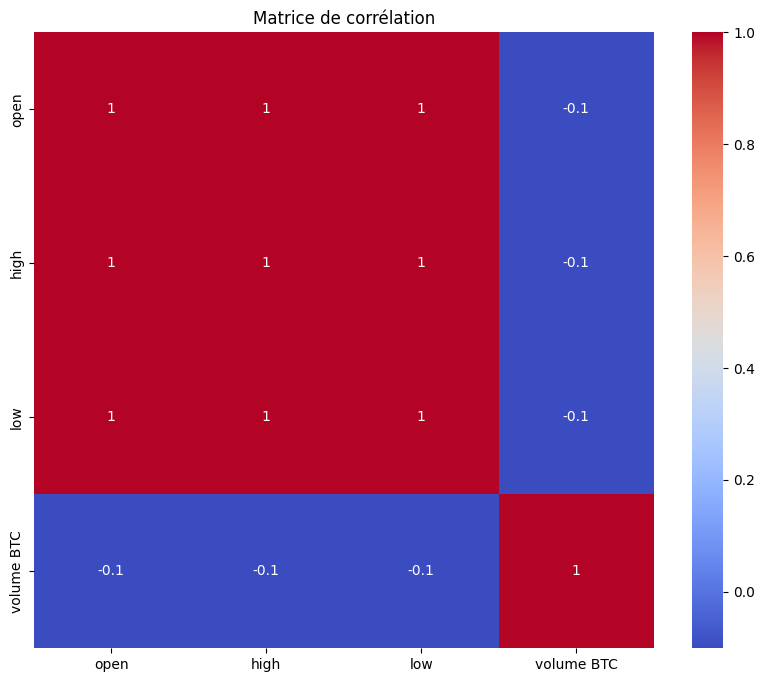

In [0]:
import seaborn as sns

# Calcul de la matrice de corrélation
correlation_matrix = df.select(continuous_vars).toPandas().corr()

# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

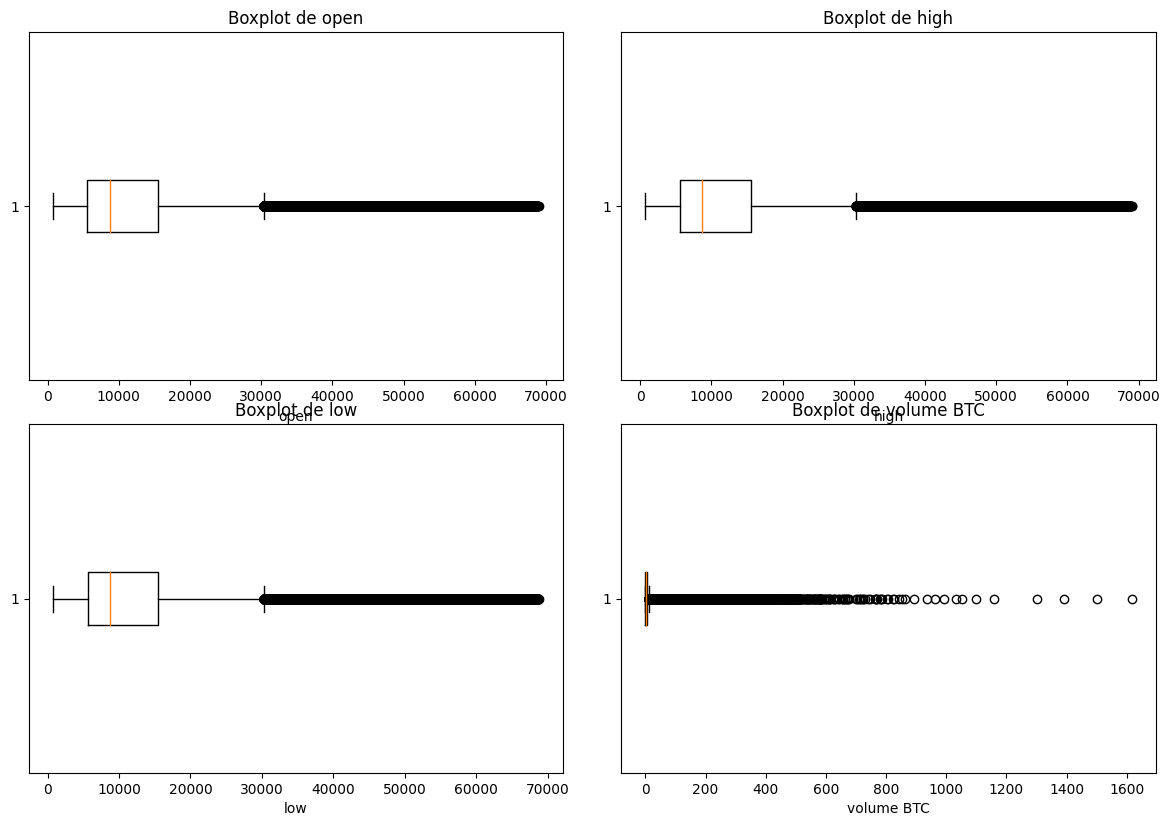

In [0]:
# Création de boxplots pour chaque variable continue
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout()

for i, var in enumerate(continuous_vars):
    ax = axs[i//2, i%2]
    ax.boxplot(df.select(var).rdd.flatMap(lambda x: x).collect(), vert=False)
    ax.set_title(f"Boxplot de {var}")
    ax.set_xlabel(var)

plt.show()

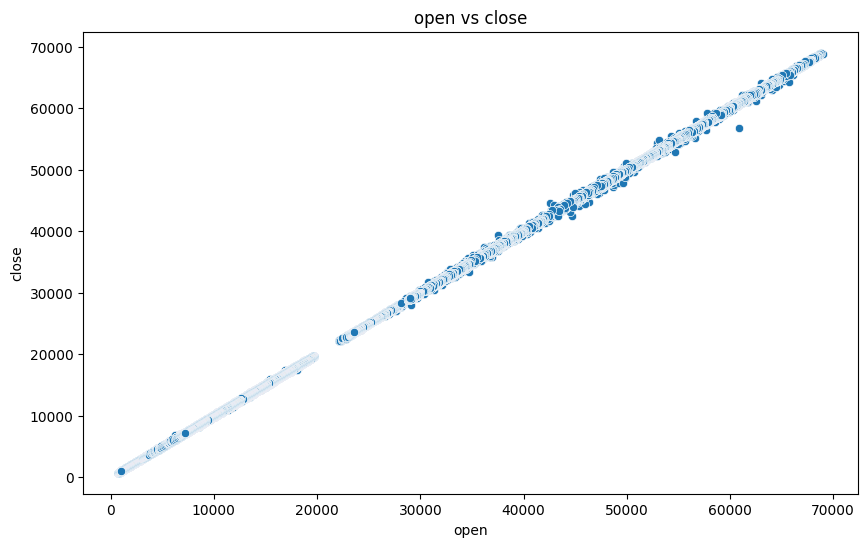

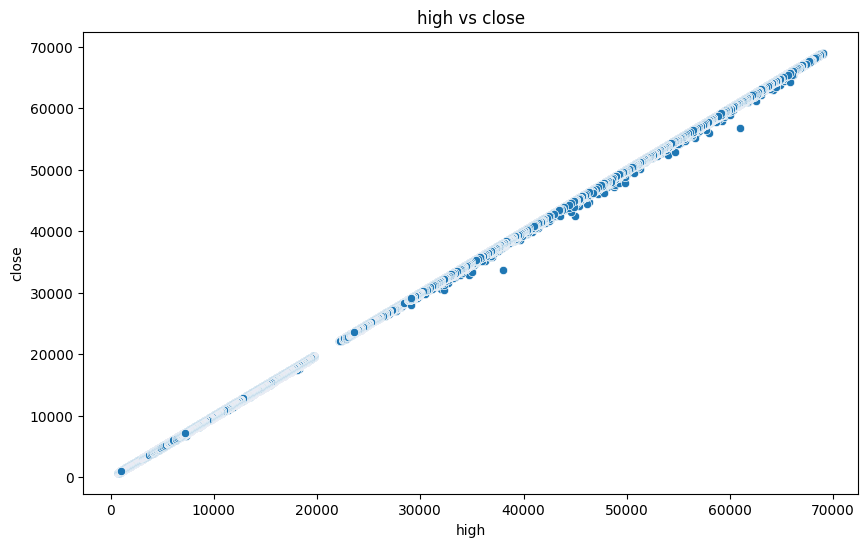

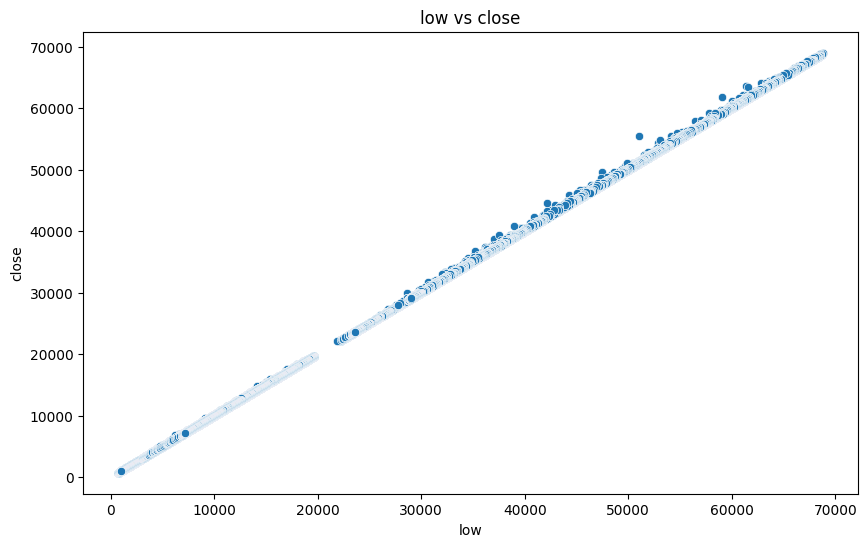

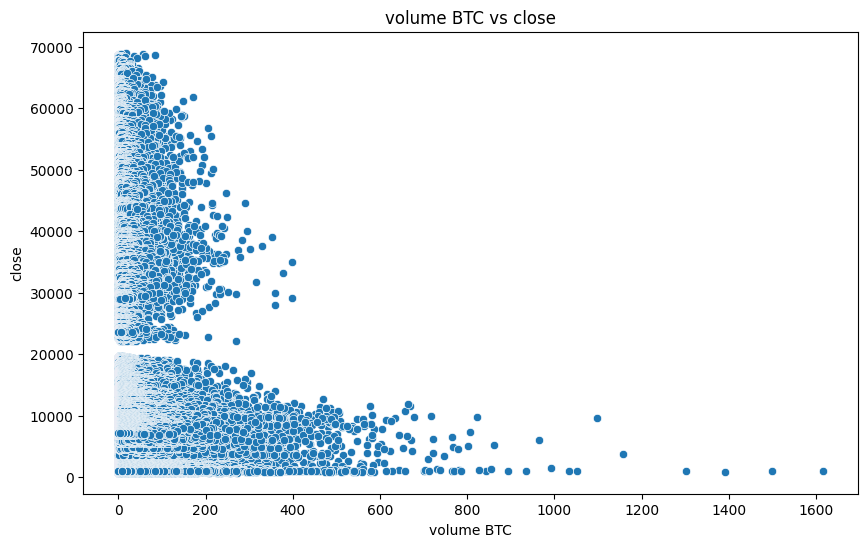

In [0]:
# Création de nuages de points pour visualiser les relations entre les variables indépendantes et la variable dépendante
variables_dependantes = ['close']

for dep_var in variables_dependantes:
    for indep_var in continuous_vars:
        if indep_var != dep_var:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=df.select(indep_var).toPandas()[indep_var], y=df.select(dep_var).toPandas()[dep_var])
            plt.title(f'{indep_var} vs {dep_var}')
            plt.xlabel(indep_var)
            plt.ylabel(dep_var)
            plt.show()



In [0]:
# Prétraitement des données
df = df.dropna().dropDuplicates()
quantiles = df.approxQuantile("close", [0.25, 0.75], 0.05)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df.filter((col("close") >= lower_bound) & (col("close") <= upper_bound))

# Conversion et extraction des caractéristiques temporelles
df = df.withColumn("date", to_timestamp(col("date"), "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("hour", hour(col("date")))
df = df.withColumn("dayofweek", dayofweek(col("date")))
df = df.withColumn("month", month(col("date")))
df = df.withColumn("year", year(col("date")))
df = df.drop("date", "symbol")

# Assemblage des caractéristiques
features = df.columns
features.remove('close')
assembler = VectorAssembler(inputCols=features, outputCol="caractéristiques")
df = assembler.transform(df)


# Standardiser les caractéristiques
scaler = StandardScaler(inputCol="caractéristiques", outputCol="features", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)

In [0]:
#Séparation des données en ensembles d'entraînement et de test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Liste des algorithmes
algorithmes = ['Régression Linéaire', 'Arbre de Décision', 'Forêt Aléatoire', 'Gradient Boosting']

# Liste des modèles correspondants aux algorithmes
modeles = [LinearRegression(featuresCol='features', labelCol='close'),
          DecisionTreeRegressor(featuresCol='features', labelCol='close'),
          RandomForestRegressor(featuresCol='features', labelCol='close'),
          GBTRegressor(featuresCol='features', labelCol='close')]

# Initialisation des listes pour stocker les résultats
rmses, maes, r2s, temps_entrainements, temps_predictions = [], [], [], [], []

# Boucle pour entraîner les modèles et obtenir les prédictions
for modele, nom in zip(modeles, algorithmes):
    start_time = time.time()
    modele_entraine = modele.fit(train_df)
    temps_entrainement = time.time() - start_time

    start_time = time.time()
    predictions = modele_entraine.transform(test_df)
    temps_prediction = time.time() - start_time

    # Calcul des métriques de performance
    rmse = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse").evaluate(predictions)
    mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae").evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2").evaluate(predictions)
    
    # Stockage des résultats
    rmses.append(rmse)
    maes.append(mae)
    r2s.append(r2)
    temps_entrainements.append(temps_entrainement)
    temps_predictions.append(temps_prediction)

    # Affichage des résultats
    print(f"{nom} - RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")
    print(f"  Temps d'Entraînement: {temps_entrainement}s")
    print(f"  Temps de Prédiction: {temps_prediction}s")

    # Stockage des prédictions selon le modèle
    if nom == 'Régression Linéaire':
        predictions_lr = predictions
    elif nom == 'Arbre de Décision':
        predictions_dt = predictions
    elif nom == 'Forêt Aléatoire':
        predictions_rf = predictions
    elif nom == 'Gradient Boosting':
        predictions_gbt = predictions

Régression Linéaire - RMSE: 6.147211582087783
  MAE: 3.2344041539739976
  R2: 0.9999977499939127
  Temps d'Entraînement: 14.647612571716309s
  Temps de Prédiction: 0.025290250778198242s
Arbre de Décision - RMSE: 454.77991523494705
  MAE: 197.51553838047454
  R2: 0.9876851274101273
  Temps d'Entraînement: 10.554414987564087s
  Temps de Prédiction: 0.022979259490966797s
Forêt Aléatoire - RMSE: 536.5295304606714
  MAE: 198.03165506853207
  R2: 0.9828598494959433
  Temps d'Entraînement: 13.721790313720703s
  Temps de Prédiction: 1.5246107578277588s
Gradient Boosting - RMSE: 264.4708996952833
  MAE: 135.0041924928946
  R2: 0.995835305441349
  Temps d'Entraînement: 35.93426442146301s
  Temps de Prédiction: 0.5741333961486816s


In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time

#Modèle XGBoost
#Préparation des données
# Convertir les données Spark en Pandas
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Préparer les matrices de caractéristiques et les cibles
X_train = np.array(train_pandas[features].values.tolist())
y_train = train_pandas['close']
X_test = np.array(test_pandas[features].values.tolist())
y_test = test_pandas['close']
#Construction et Entraînement du Modèle XGBoost
# Entraîner le modèle XGBoost
start_time = time.time()
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
xgb_predictions = xgb_model.predict(X_test)
xgb_prediction_time = time.time() - start_time

# Calculer RMSE, MAE, R²
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("XGBoost - RMSE:", xgb_rmse)
print("MAE:", xgb_mae)
print("R2:", xgb_r2)
print("Temps d'Entraînement:", xgb_train_time, "s")
print("Temps de Prédiction:", xgb_prediction_time, "s")

XGBoost - RMSE: 29.73441115391779
MAE: 15.07870512877264
R2: 0.9999471523948713
Temps d'Entraînement: 4.81927752494812 s
Temps de Prédiction: 0.23344111442565918 s


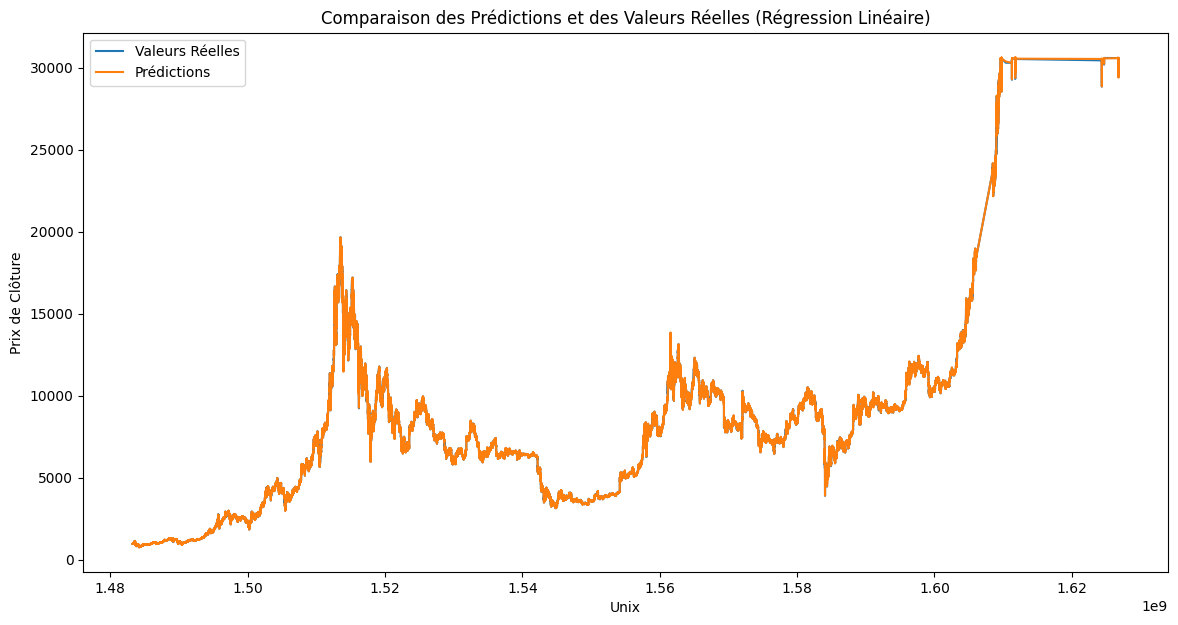

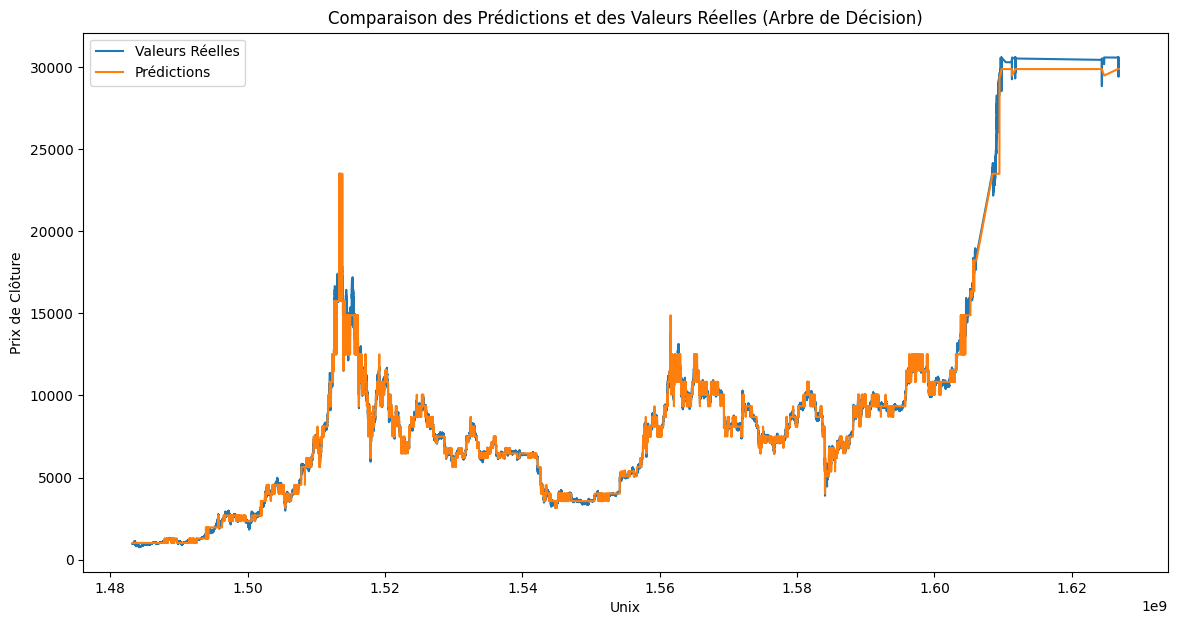

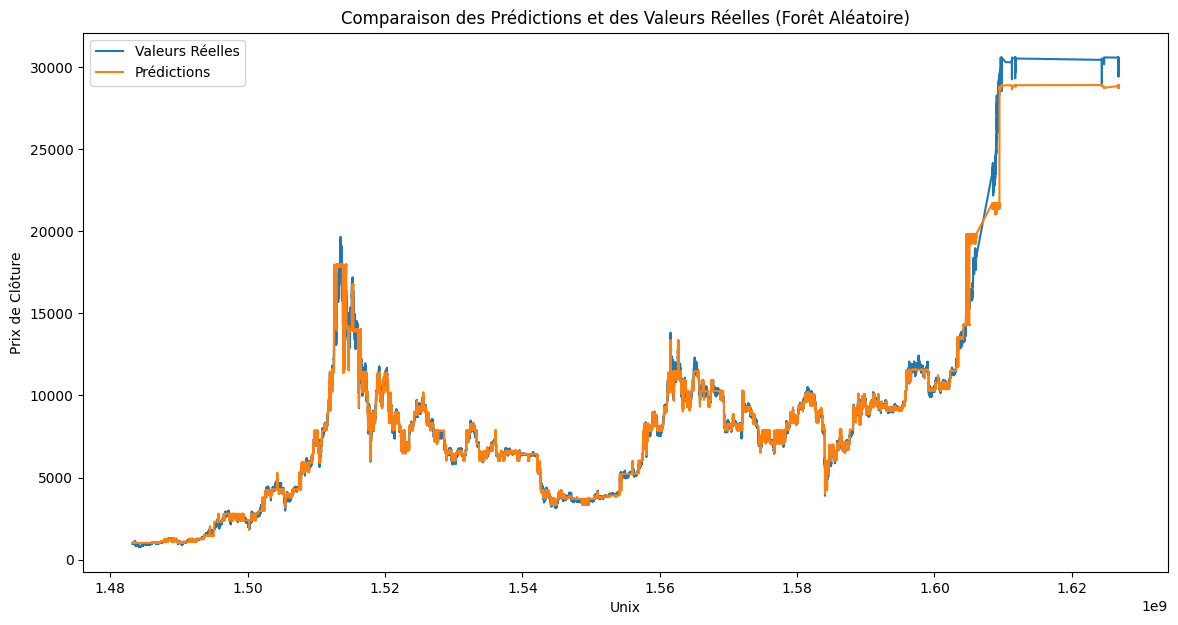

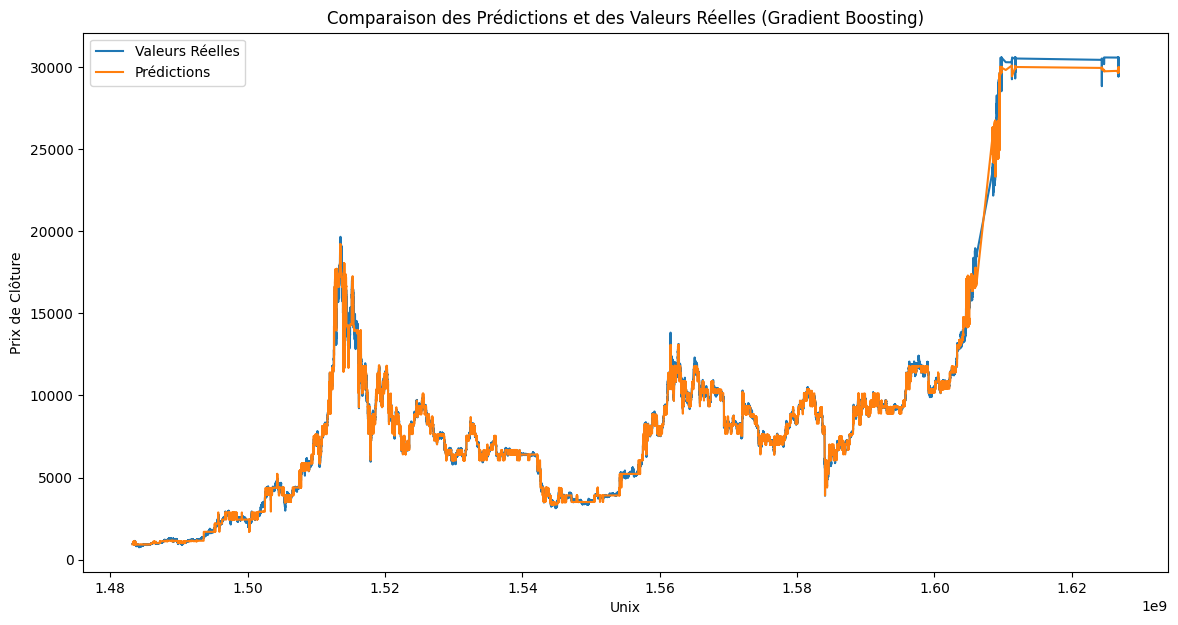

In [0]:
# Visualisation des prédictions vs valeurs réelles pour la Régression Linéaire
predictions_lr_pandas = predictions_lr.select("close", "prediction", "unix").orderBy("unix").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(predictions_lr_pandas["unix"], predictions_lr_pandas['close'], label='Valeurs Réelles')
plt.plot(predictions_lr_pandas["unix"], predictions_lr_pandas['prediction'], label='Prédictions')
plt.title('Comparaison des Prédictions et des Valeurs Réelles (Régression Linéaire)')
plt.xlabel('Unix')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

# Visualisation des prédictions vs valeurs réelles pour l'Arbre de Décision
predictions_dt_pandas = predictions_dt.select("close", "prediction", "unix").orderBy("unix").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(predictions_dt_pandas["unix"], predictions_dt_pandas['close'], label='Valeurs Réelles')
plt.plot(predictions_dt_pandas["unix"], predictions_dt_pandas['prediction'], label='Prédictions')
plt.title('Comparaison des Prédictions et des Valeurs Réelles (Arbre de Décision)')
plt.xlabel('Unix')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

# Visualisation des prédictions vs valeurs réelles pour la Forêt Aléatoire
predictions_rf_pandas = predictions_rf.select("close", "prediction", "unix").orderBy("unix").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(predictions_rf_pandas["unix"], predictions_rf_pandas['close'], label='Valeurs Réelles')
plt.plot(predictions_rf_pandas["unix"], predictions_rf_pandas['prediction'], label='Prédictions')
plt.title('Comparaison des Prédictions et des Valeurs Réelles (Forêt Aléatoire)')
plt.xlabel('Unix')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

# Visualisation des prédictions vs valeurs réelles pour le Gradient Boosting
predictions_gbt_pandas = predictions_gbt.select("close", "prediction", "unix").orderBy("unix").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(predictions_gbt_pandas["unix"], predictions_gbt_pandas['close'], label='Valeurs Réelles')
plt.plot(predictions_gbt_pandas["unix"], predictions_gbt_pandas['prediction'], label='Prédictions')
plt.title('Comparaison des Prédictions et des Valeurs Réelles (Gradient Boosting)')
plt.xlabel('Unix')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

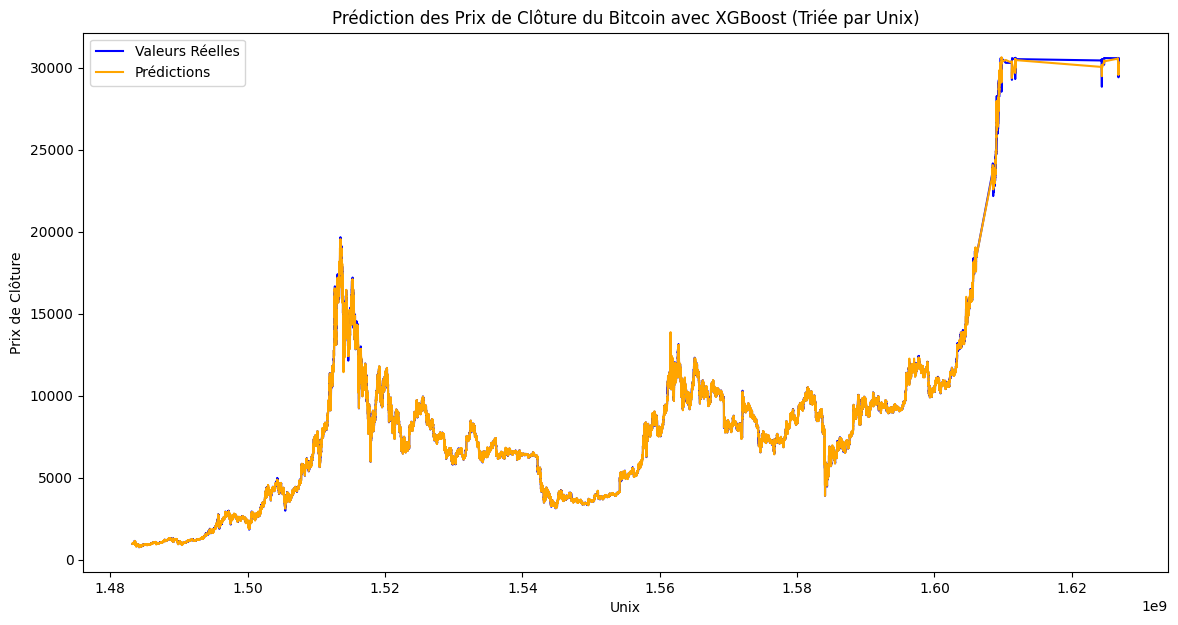

In [0]:
# Visualisation des résultats
predictions_df = pd.DataFrame({'close': y_test, 'prediction': xgb_predictions, 'unix': test_pandas['unix']})

# Sort the dataframe by 'unix' column
sorted_predictions_df = predictions_df.sort_values('unix')

plt.figure(figsize=(14, 7))
plt.plot(sorted_predictions_df['unix'], sorted_predictions_df['close'], color='blue', label='Valeurs Réelles')
plt.plot(sorted_predictions_df['unix'], sorted_predictions_df['prediction'],color='orange', label='Prédictions')
plt.title("Prédiction des Prix de Clôture du Bitcoin avec XGBoost (Triée par Unix)")
plt.xlabel('Unix')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

Text(0, 0.5, 'R2')

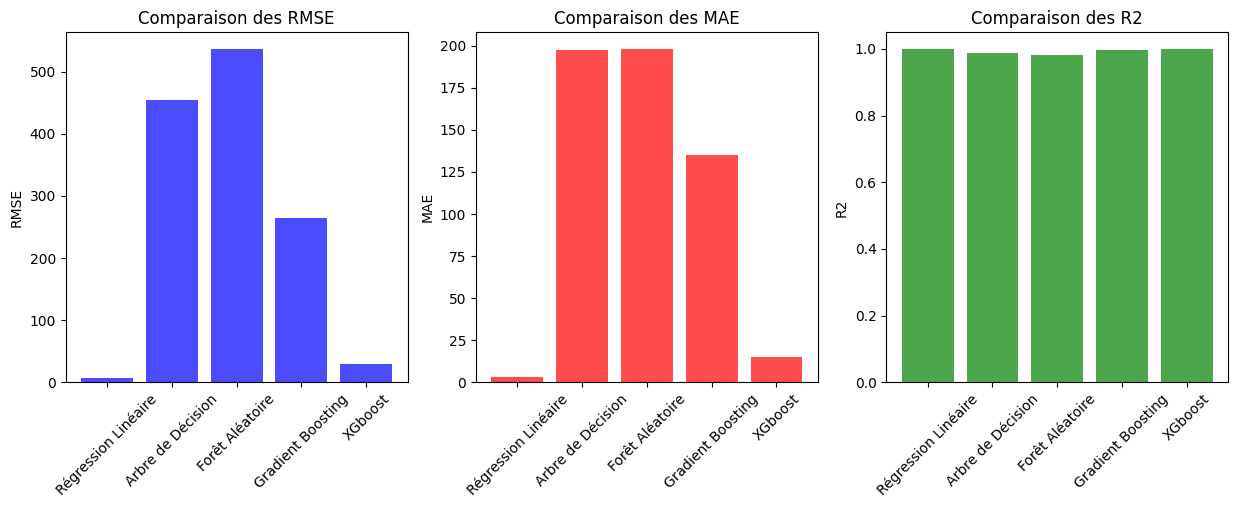

In [0]:
# Comparaison des performances des modèles
algorithmes.append('XGboost')
x = range(len(algorithmes))

plt.figure(figsize=(15, 10))
rmses.append(xgb_rmse)
maes.append(xgb_mae)
r2s.append(xgb_r2)

# Graphique RMSE
plt.subplot(2, 3, 1)
plt.bar(x, rmses, color='b', alpha=0.7)
plt.xticks(x, algorithmes, rotation=45)
plt.title('Comparaison des RMSE')
plt.ylabel('RMSE')

# Graphique MAE
plt.subplot(2, 3, 2)
plt.bar(x, maes, color='r', alpha=0.7)
plt.xticks(x, algorithmes, rotation=45)
plt.title('Comparaison des MAE')
plt.ylabel('MAE')

# Graphique R2
plt.subplot(2, 3, 3)
plt.bar(x, r2s, color='g', alpha=0.7)
plt.xticks(x, algorithmes, rotation=45)
plt.title('Comparaison des R2')
plt.ylabel('R2')



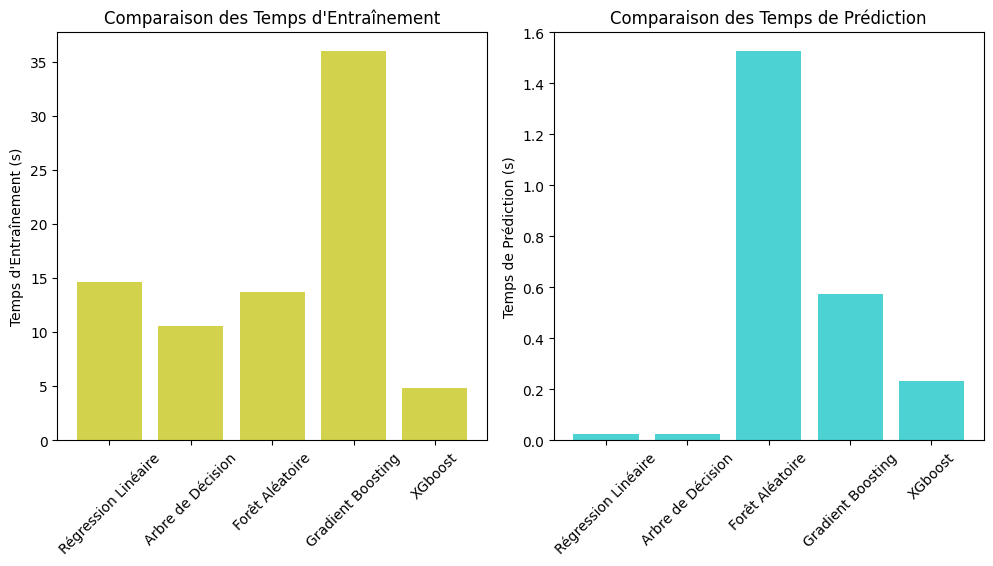

In [0]:
# Graphique du temps d'entraînement
temps_entrainements.append(xgb_train_time)
temps_predictions.append(xgb_prediction_time)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 4)
plt.bar(x, temps_entrainements, color='y', alpha=0.7)
plt.xticks(x, algorithmes, rotation=45)
plt.title('Comparaison des Temps d\'Entraînement')
plt.ylabel('Temps d\'Entraînement (s)')

# Graphique du temps de prédiction
plt.subplot(2, 3, 5)
plt.bar(x, temps_predictions, color='c', alpha=0.7)
plt.xticks(x, algorithmes, rotation=45)
plt.title('Comparaison des Temps de Prédiction')
plt.ylabel('Temps de Prédiction (s)')

plt.tight_layout()
plt.show()

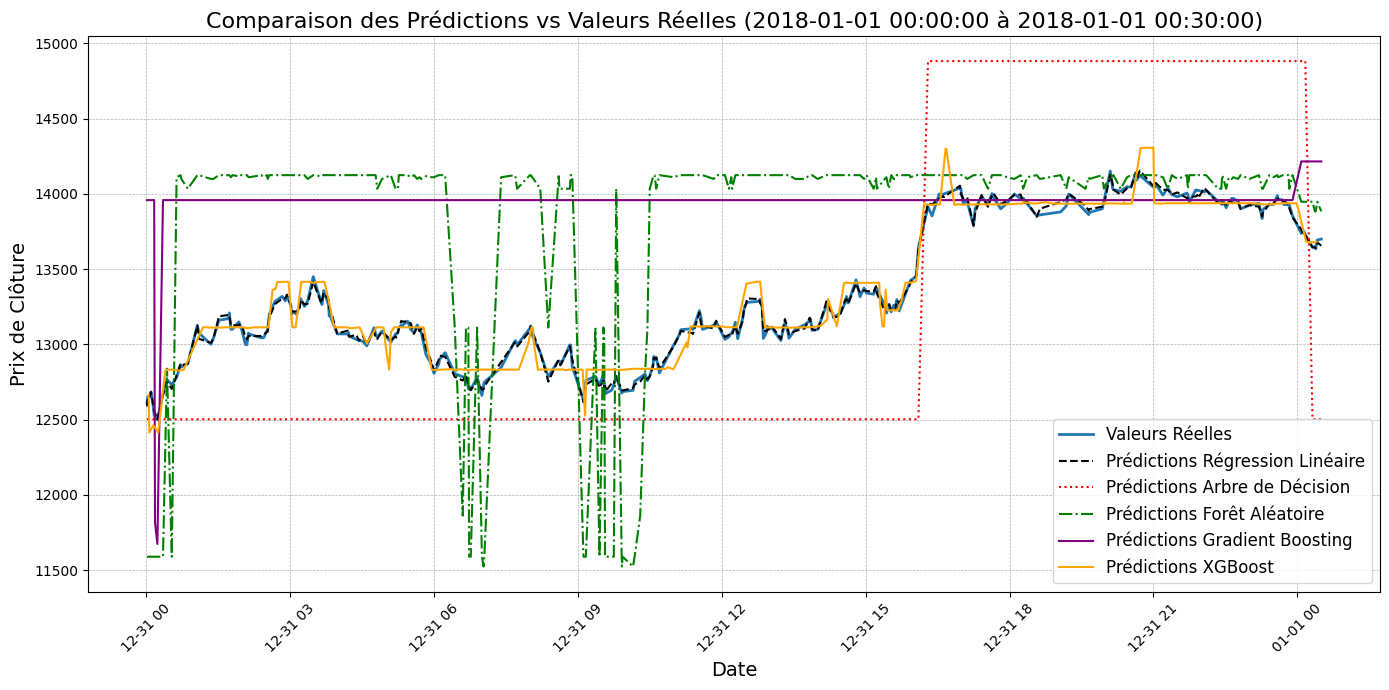

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Convertir les timestamps unix en datetime et filtrer les données pour la période spécifiée
def filtrer_donnees(df):
    df['datetime'] = pd.to_datetime(df['unix'], unit='s')
    return df[(df['datetime'] >= '2017-12-31 00:00:00') & (df['datetime'] <= '2018-01-01 00:30:00')]

# Charger et filtrer les prédictions
predictions_lr_pandas = filtrer_donnees(predictions_lr.select("close", "prediction", "unix").orderBy("unix").toPandas())
predictions_dt_pandas = filtrer_donnees(predictions_dt.select("close", "prediction", "unix").orderBy("unix").toPandas())
predictions_rf_pandas = filtrer_donnees(predictions_rf.select("close", "prediction", "unix").orderBy("unix").toPandas())
predictions_gbt_pandas = filtrer_donnees(predictions_gbt.select("close", "prediction", "unix").orderBy("unix").toPandas())

# Convertir vos prédictions XGBoost DataFrame et les filtrer
predictions_xgb_pandas = pd.DataFrame({'close': y_test, 'prediction': xgb_predictions, 'unix': test_pandas['unix']})
predictions_xgb_pandas = filtrer_donnees(predictions_xgb_pandas.sort_values('unix'))

# Tracer toutes les prédictions vs valeurs réelles dans un seul graphique
plt.figure(figsize=(14, 7))

# Tracer les valeurs réelles
plt.plot(predictions_lr_pandas["datetime"], predictions_lr_pandas['close'], label='Valeurs Réelles',  linewidth=2)

# Tracer les prédictions pour chaque modèle
plt.plot(predictions_lr_pandas["datetime"], predictions_lr_pandas['prediction'], label='Prédictions Régression Linéaire', linestyle='dashed', color='black', linewidth=1.5)
plt.plot(predictions_dt_pandas["datetime"], predictions_dt_pandas['prediction'], label='Prédictions Arbre de Décision', linestyle='dotted', color='red', linewidth=1.5)
plt.plot(predictions_rf_pandas["datetime"], predictions_rf_pandas['prediction'], label='Prédictions Forêt Aléatoire', linestyle='dashdot', color='green', linewidth=1.5)
plt.plot(predictions_gbt_pandas["datetime"], predictions_gbt_pandas['prediction'], label='Prédictions Gradient Boosting', linestyle='solid', color='purple', linewidth=1.5)
plt.plot(predictions_xgb_pandas["datetime"], predictions_xgb_pandas['prediction'], label='Prédictions XGBoost', linestyle='solid', color='orange', linewidth=1.5)

# Personnaliser le graphique
plt.title('Comparaison des Prédictions vs Valeurs Réelles (2018-01-01 00:00:00 à 2018-01-01 00:30:00)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Prix de Clôture', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

# Afficher le graphique
plt.tight_layout()
plt.show()